In [307]:
import praw
import pandas as pd
from praw.models import MoreComments
import datetime as dt
from datetime import date
import numpy as np

In [308]:
payload=pd.read_html('https://en.wikipedia.org/wiki/S%26P_100')
thr = payload[2]
thr.head()
symbols = thr['Symbol'].values.tolist()
symbols = [i.lower() for i in symbols]
# # symbols = set(symbols)
names = thr['Name'].values.tolist()
names = [i.lower() for i in names]

symbols.remove("so")
symbols.remove("low")
symbols.remove("f")
symbols.remove("cost")

names.remove("lowe's")
names.remove("ford")
names.remove("southern company")
names.remove("costco")
helper = {}
for i in range(len(symbols)):
    helper[symbols[i]] = names[i]


In [309]:
# input : Set of String, Integer, String
# Set of String = Keywords
# Integer = Postcount to evaluate
# String = Subreddit Name
# Boolean - check if data should be written
def redditFilterHot(tsla, post_count, subreddit, txt):
    #using API key create instance of Reddit for PRAW
    reddit = praw.Reddit(client_id="H2yrxHGdrXYUxexBul36Zw", client_secret = 'mouzzGMwsNMquUX4EA-GF_9BjAIyvA', user_agent = "wsbWebScraping")
    #selecting subreddit
    sr = reddit.subreddit(subreddit)
    
    
    # Create Dataframe
    posts = []
    for post in sr.hot(limit=post_count):
        posts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created])
    posts = pd.DataFrame(posts,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created'])
    
    
    # Open File to Add Data to text file
    if (txt):
        today = date.today()
        use = today.strftime("%d-%m-%y")
        file = open(f"collection/{use}.txt", mode="w+")
        file.write("Author,Body")
    
    # Adding DataFrame
    dictionary = {"Author":[], "Body":[], "Upvotes":[], "Tag":[]}
    
    
    #parse through every post in dataframe
    # TODO : optimize -- likely more efficient way to access posts directly through dataframe
    for num in range(len(posts["url"])):
        # parse through all comments --> including subcomments
        # utilize try block --> avoid invalid URLs
        try: 
    #opens post
            submission = reddit.submission(url = posts["url"][num])
    #skip reddit buttons that are not posts
            for c in submission.comments.list():
                if isinstance(c, MoreComments):
                    continue
    #comparing sets to see if common keywords
                if not tsla.isdisjoint(set(c.body.lower().split(" "))):
    #cleaning up print
    #TODO - Make it more clean
    #printing disabled for now
                    #print(f'''
#______________________________________________________________
#{c.author}:
#--------------------------------------------------------------
#{c.body}
#______________________________________________________________
                    #''')
        #Write to TXT File
                    #if txt:
                        #file.write(f"{c.author},{c.body}\n")
                    
                    # DataFrame
                    dictionary["Author"].append(c.author)
                    dictionary["Body"].append(c.body)
                    dictionary["Upvotes"].append(c.score)
                    dictionary["Tag"].append(tsla.intersection(set(c.body.lower().split(" "))))
        except:
            pass
    df = pd.DataFrame(dictionary)
    if txt:
        file.write(df.to_csv())
    return df
    
    

In [310]:
tsla = {"tesla", "tsla", "elon"}
tsla = set(symbols).union(set(names))
pc = 50
sr = "wallstreetbets"
collection = redditFilterHot(tsla, pc, sr, True)


In [311]:
from textblob import TextBlob

In [312]:
blobb = TextBlob("I hate these people but however i also love the way that they are damaging society")
print(blobb.sentiment)

Sentiment(polarity=-0.15000000000000002, subjectivity=0.75)


In [313]:

def lamb(sentence):
    blob = TextBlob(sentence)
    return blob.sentiment.polarity

In [314]:
collection["Sentiment"] = collection["Body"].apply(lamb)
collection

,Author,Body,Upvotes,Tag,Sentiment
0,Realistic-Duck632,Today is the day tesla loses 600 and I make en...,41,{tesla},-0.150000
1,VisualMod,#Ban Bet Won\n---\n\n/u/HelloTheirCruleWorld (...,31,{tsla},-0.900000
2,VinnyIrish,"Everyone says NVDA poots, so call’s should print",17,{nvda},0.000000
3,willard_tagg,june/july is going to be a disaster. think abo...,17,{apple},0.000000
4,DiamondHands007,TSLA puts,16,{tsla},0.000000
...,...,...,...,...,...
223,Ofiller,I wanted to buy a TSLA 750 PUT a few months ag...,2,{tsla},-0.096190
224,DiamondHands007,AMZN 5/27 2150 2130 / 2000P\n\nGOOGL 5/27 2200...,4,{amzn},0.000000
225,DiamondHands007,Yes. That's why I closed those out this mornin...,3,"{met, nvda}",-0.051389
226,Ofiller,"My 410 would be red af now, I think. I sold i...",3,{tsla},-0.024833


In [315]:
percompany = pd.DataFrame()
percompany['Ticker'] = symbols
percompany.head()
percompany['Mentions'] = percompany['Ticker']


In [316]:
def mentions(ticker):    
    tr = 0
    for i in range(len(collection)):
        if ticker in (collection.loc[i, "Tag"]) or helper[ticker] in (collection.loc[i, "Tag"]):
            tr += 1
    return tr

In [317]:
percompany['Mentions'] = percompany['Ticker'].apply(mentions)

In [318]:
def upvotes(ticker):
    tr = 0
    for i in range(len(collection)):
        if ticker in (collection.loc[i, "Tag"]) or helper[ticker] in (collection.loc[i, "Tag"]):
            tr += collection.loc[i, "Upvotes"]
    return tr

In [319]:
percompany['Upvotes'] = percompany['Ticker'].apply(upvotes)
percompany

,Ticker,Mentions,Upvotes
0,aapl,9,64
1,abbv,0,0
2,abt,0,0
3,acn,0,0
4,adbe,0,0
...,...,...,...
92,vz,0,0
93,wba,0,0
94,wfc,0,0
95,wmt,0,0


In [320]:
def weightedsentiment(ticker):
    tr = 0
    if (upvotes(ticker) == 0):
        return 0
    for i in range(len(collection)):
        if ticker in (collection.loc[i, "Tag"]) or helper[ticker] in (collection.loc[i, "Tag"]):
            b = 0
            try:
                b = collection.loc[i, "Sentiment"]
            except:
                print("here")
                b = 0
            tr += b * collection.loc[i, "Upvotes"];
    
    tr = tr/upvotes(ticker)
    return tr

In [321]:
percompany['Weighted Sentiment'] = percompany['Ticker'].apply(weightedsentiment)
percompany['row_num'] = np.arange(len(percompany))

In [328]:
culled = percompany[percompany["Mentions"] != 0]
culled["WeightRank"] = (culled["Weighted Sentiment"]).rank(method="max")
culled

<ipython-input-328-32ef906baa5d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  culled["WeightRank"] = (culled["Weighted Sentiment"]).rank(method="max")


,Ticker,Mentions,Upvotes,Weighted Sentiment,row_num,WeightRank
0,aapl,9,64,-0.018395,0,8.0
5,aig,1,24,0.600000,5,30.0
8,amzn,11,59,0.164332,8,23.0
11,ba,2,56,-0.141273,11,5.0
15,blk,2,16,0.000000,15,13.0
18,c,5,56,0.183661,18,24.0
19,cat,1,10,-0.200000,19,2.0
29,dd,2,8,0.156250,29,22.0
31,dis,2,52,0.459615,31,29.0
36,fb,1,1,-0.156250,36,4.0


In [329]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [330]:
print(culled.shape[0])
for line in range(0,culled.shape[0]):
     if (percompany["Mentions"][line] != 0):
        #   ax.text(culled.Mentions[line], culled.row_num[line], culled.Ticker[line], horizontalalignment='center', size='large', color='black', weight='semibold')
        print(percompany["Mentions"][line])

31
9
1
11
2
2
5
1
2


c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


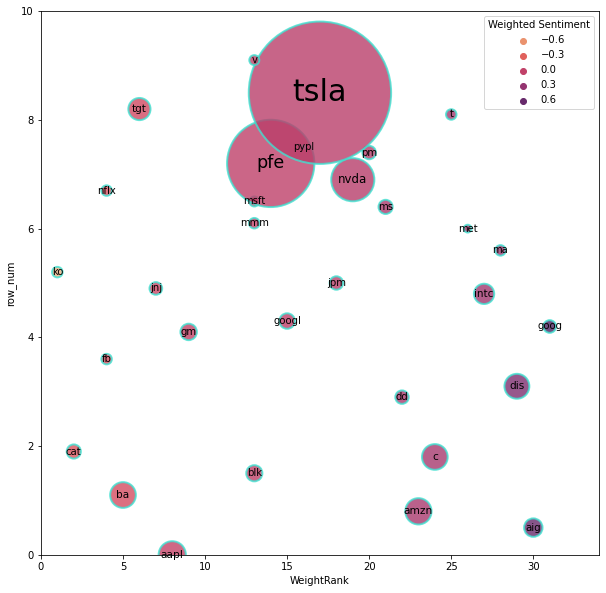

In [331]:
plt.figure(figsize = (10,10))

# Create scatterplot. alpha controls the opacity and s controls the size.
ax = sns.scatterplot(culled["WeightRank"], culled.row_num/10, alpha = 0.8,s = 100 + culled['Upvotes']*10, hue=culled["Weighted Sentiment"], palette="flare", edgecolor='turquoise', linewidth = 2)

ax.set_xlim(0,max(culled["WeightRank"])+3)
ax.set_ylim(0, 10)

#For each point, we add a text inside the bubble
for line in range(0,percompany.shape[0]):
     if (percompany["Mentions"][line] != 0):
          ax.text(culled["WeightRank"][line], culled.row_num[line]/10, culled.Ticker[line], horizontalalignment='center', size=10 + culled['Upvotes'][line]/100, color='black', verticalalignment='center')


In [326]:
today = date.today()
use = today.strftime("%d-%m-%y")
ax.figure.savefig(f"images/{use}.png")